# CNN Model Development

This notebook demonstrates how to load models and datasets for model development. Note that this notebook is used for demonstration and debugging purposes only. 

For the actual model training, run `python src/train_cnn.py`:
```s
usage: train_cnn.py [-h] [--cnn_config CNN_CONFIG] [--lr_finder LR_FINDER] [--iso ISO [ISO ...]]

Model Training
options:
  -h, --help              show this help message and exit
  --cnn_config CNN_CONFIG Path to the configuration file
  --lr_finder LR_FINDER   Learning rate finder (boolean indicator)
  --iso ISO [ISO ...]     ISO 3166-1 alpha-3 codes
```

## Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import cnn_utils
from utils import config_utils

import torchsummary
import torch

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Configuration

In [9]:
iso_code = "SEN"
config_file = "configs/cnn_configs/convnext_large_v01.yaml"

config = config_utils.load_config(os.path.join(os.getcwd(), config_file))
config["iso_codes"] = [iso_code]
data, data_loader, classes = cnn_utils.load_dataset(config, phases=["train", "val", "test"])

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/GIGAv4/train/SEN_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  SEN  non_school   7141    0.372043
1  rural  SEN      school   4443    0.231479
2  urban  SEN  non_school   5655    0.294623
3  urban  SEN      school   1955    0.101855
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  SEN non_school test       712    0.371027
                      train     5765         NaN
                      val        664    0.346014
           school     test       446    0.232413
                      train     3585         NaN
                      val        412    0.214695
urban  SEN non_school test       565    0.294424
                      train     4529         NaN
                      val        561    0.292340
           school     test       195    0.101615
                      train     1582         NaN
                      

## Visualize Samples

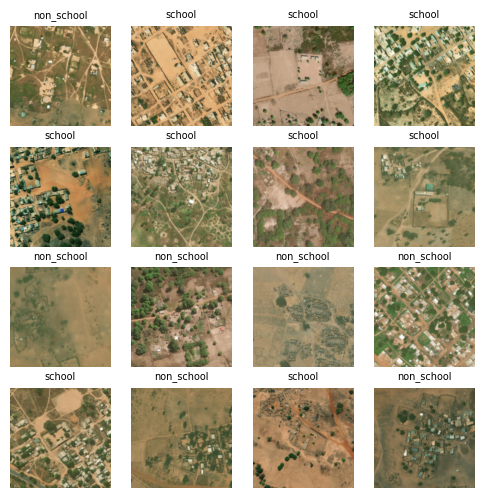

In [10]:
cnn_utils.visualize_data(data, data_loader, phase='train', normalize=config["normalize"])

## Load Model

In [20]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=2,
    data_loader=data_loader,
    model_type=config["model"],
    pretrained=config["pretrained"],
    scheduler_type=config["scheduler"],
    optimizer_type=config["optimizer"],
    label_smoothing=config["label_smoothing"],
    lr=config["lr"],
    momentum=config["momentum"],
    gamma=config["gamma"],
    step_size=config["step_size"],
    patience=config["patience"],
    dropout=config["dropout"],
    lr_finder=False,
    device=device
)
torchsummary.summary(model, (3, 500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 192, 125, 125]           9,408
       LayerNorm2d-2        [-1, 192, 125, 125]             384
            Conv2d-3        [-1, 192, 125, 125]           9,600
           Permute-4        [-1, 125, 125, 192]               0
         LayerNorm-5        [-1, 125, 125, 192]             384
            Linear-6        [-1, 125, 125, 768]         148,224
              GELU-7        [-1, 125, 125, 768]               0
            Linear-8        [-1, 125, 125, 192]         147,648
           Permute-9        [-1, 192, 125, 125]               0
  StochasticDepth-10        [-1, 192, 125, 125]               0
          CNBlock-11        [-1, 192, 125, 125]               0
           Conv2d-12        [-1, 192, 125, 125]           9,600
          Permute-13        [-1, 125, 125, 192]               0
        LayerNorm-14        [-1, 125, 1

## Learning Rate Finder

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.91E-04


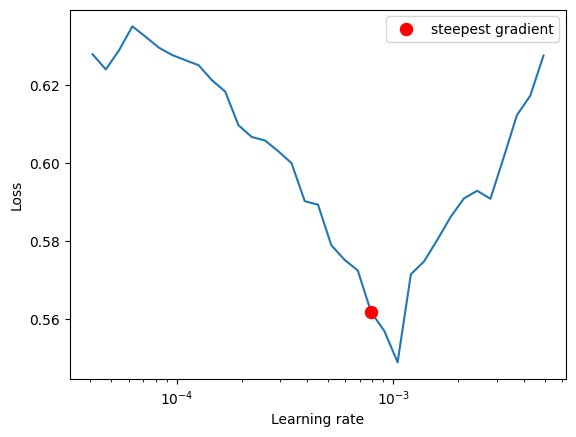

INFO:root:Best lr: 0.0007906043210907702


In [22]:
lr = cnn_utils.run_lr_finder(
    data_loader, 
    model, 
    optimizer, 
    criterion, 
    device,
    start_lr=1e-5,
    end_lr=1e-2, 
    num_iter=50, 
    plot=True
)